In [3]:
import sys
import os

# Adiciona o diretório src ao PATH do Python
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
from pathlib import Path
import os

from kedro.config import OmegaConfigLoader
from kedro.io import DataCatalog
from kedro_datasets.partitions.partitioned_dataset import PartitionedDataset
#from mca.src.mca.custom_data.year_partition import YearPartitionsDataset
from mca.custom_data.year_partition import YearPartitionsDataset
from mca.custom_data.versus_scenarios import VersusScenarios
# Caminho base do projeto
#base_path = Path(__file__).resolve().parents[2]  # src/mca/
base_path = Path.cwd().parents[1] / 'mca/'  # Ajuste conforme sua estrutura
conf_path = base_path / "conf" / "base"
#conf_path = "conf/base"
# Carrega configs
conf_loader = OmegaConfigLoader(str(conf_path))
catalog_config = conf_loader["catalog"]
catalog = DataCatalog.from_config(catalog_config)
catalog.list()

Raw config received: {'path': 'data/01_raw/LolHistoric', 'dataset': {'type': 'pandas.CSVDataset', 'load_args': {'sep': ',', 'encoding': 'utf-8'}}}
Raw config received: {'path': 'data/03_primary/versusScenarios', 'dataset': {'type': 'pandas.CSVDataset', 'load_args': {'sep': ',', 'encoding': 'utf-8'}, 'save_args': {'index': False}}}


c:\Users\Micro\Documents\Projetos\MobaChampion\MobaChampionAnalysis\analysis_venv\Lib\site-packages\kedro\io\data_catalog.py:165: KedroDeprecationWarning: `DataCatalog` has been deprecated and will be replaced by `KedroDataCatalog`, in Kedro 1.0.0.Currently some `KedroDataCatalog` APIs have been retained for compatibility with `DataCatalog`, including the `datasets` property and the `get_datasets`, `_get_datasets`, `add`,` list`, `add_feed_dict`, and `shallow_copy` methods. These will be removed or replaced with updated alternatives in Kedro 1.0.0. For more details, refer to the documentation: https://docs.kedro.org/en/stable/data/index.html#kedrodatacatalog-experimental-feature
  warnings.warn(


['LolHistoric',
 'lol_historic_years',
 'metadataChampion',
 'HeroInfo_data',
 'damageTypeCount',
 'modifierNameCount',
 'attributeNameCount',
 'championCount',
 'championDamageCount',
 'championGoldCount',
 'championMinionCount',
 'championKdaCount',
 'versusScenarios']

In [5]:
data_scenarios = catalog.load("versusScenarios")

In [6]:
df = data_scenarios["2014"]

In [7]:
df

,champion_vs,win_ratio,loss_ratio,loss,pick,wins,role,champion_main
0,Aatrox,0.00,1.00,2,2,0,top,Trundle
1,Dr. Mundo,0.45,0.55,12,22,10,top,Trundle
2,Gragas,0.33,0.67,4,6,2,top,Trundle
3,Irelia,0.60,0.40,4,10,6,top,Trundle
4,Jax,0.50,0.50,4,8,4,top,Trundle
...,...,...,...,...,...,...,...,...
1439,Ahri,1.00,0.00,0,2,2,mid,Azir
1440,Ezreal,1.00,0.00,0,2,2,mid,Azir
1441,Jayce,0.00,1.00,2,2,0,mid,Azir
1442,Xerath,1.00,0.00,0,2,2,mid,Azir


In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
roles = pd.unique(df["role"]).tolist()
plt.rcParams['font.size'] = 8  # Tamanho da fonte para as anotações
options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

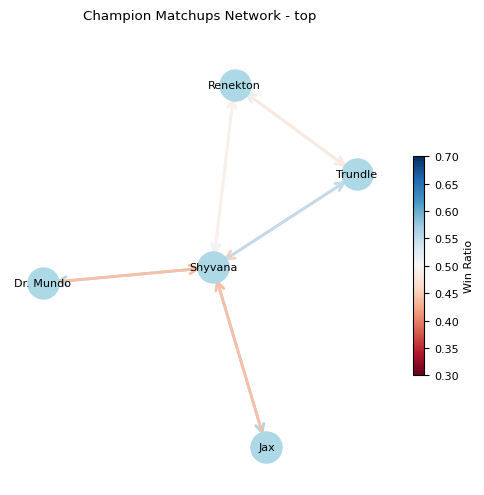

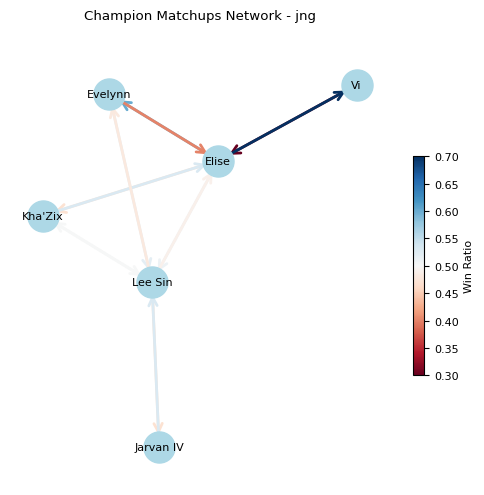

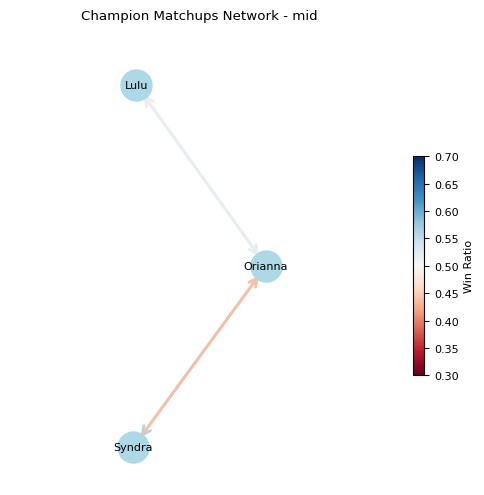

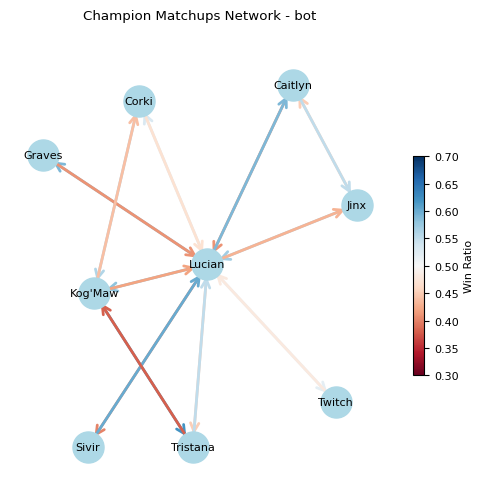

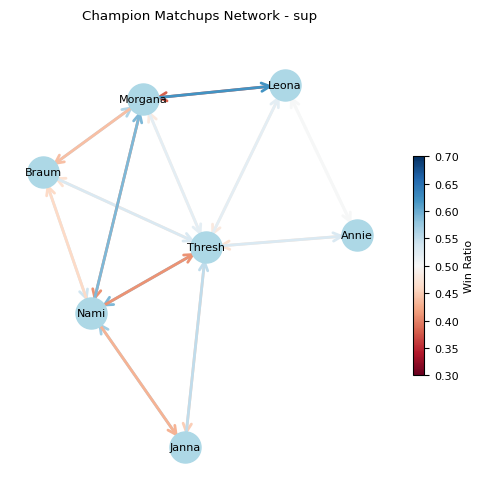

In [9]:
for r in roles:
#    import networkx as nx

#r = roles[0]  # Escolha uma role
    df_role = df.loc[df["role"] == r]

    # Filtrar apenas matchups significativos
    df_sig = df_role[df_role['pick'] > 50]  # Exemplo: mínimo 50 jogos

    # Criar o grafo
    G = nx.DiGraph()  # <--- Aqui está a mudança crucial

    # Adicionar arestas com direção (main -> vs) e atributo win_ratio
    for _, row in df_sig.iterrows():
        G.add_edge(row['champion_main'], row['champion_vs'], win_ratio=row['win_ratio'])

    # Configurar a figura
    fig, ax = plt.subplots(figsize=(5, 5))
    #pos = nx.spring_layout(G, k=0.5, seed=42)  # seed para layout consistente
    #pos = nx.circular_layout(G) 
    pos = nx.kamada_kawai_layout(G)
    # Mapear win_ratio para cores
    edge_colors = [G[u][v]['win_ratio'] for u, v in G.edges()]

    # Desenhar componentes do grafo
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    edges = nx.draw_networkx_edges(
        G, pos, 
        edge_color=edge_colors, 
        edge_cmap=plt.cm.RdBu,
        width=2,
        edge_vmin=0.3,
        edge_vmax=0.7,
        arrowstyle="->",
        arrowsize=15,
        ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Adicionar colorbar corretamente
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=plt.Normalize(vmin=0.3, vmax=0.7))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label('Win Ratio')

    plt.title(f"Champion Matchups Network - {r}", pad=20)
    plt.axis('off')  # Remove os eixos
    plt.tight_layout()
    plt.show()

In [ ]:
import plotly.graph_objects as go
from matplotlib.colors import to_hex
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

fig = go.Figure()

for r in roles:
    df_role = df.loc[df["role"] == r]
    number_games_min = df_role["pick"].sum() / 200
    
    # Filtrar matchups significativos
    df_sig = df_role[df_role['pick'] > number_games_min]

    # Criar o grafo direcionado
    G = nx.DiGraph()

    # Adicionar arestas
    for _, row in df_sig.iterrows():
        G.add_edge(row['champion_main'], row['champion_vs'], 
                  win_ratio=row['win_ratio'],
                  pick=row["pick"],main=row['champion_main'],vs=row['champion_vs'])

    # Layout do grafo
    pos = nx.kamada_kawai_layout(G)
    
    # 1. Tratamento especial para arestas bidirecionais
    edge_traces = []
    bidirectional_edges = set()
    
    # Primeiro identificar todas as arestas bidirecionais
    for u, v in list(G.edges()):
        if G.has_edge(v, u) and (v, u) not in bidirectional_edges:
            bidirectional_edges.add((u, v))
    
    # Processar arestas
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        print(G[u][v])
        # Configurações comuns
        ratio = G[u][v]['win_ratio']
        color = to_hex(plt.cm.RdBu((ratio - 0.4)/0.2))
        width = 1 + 3 * (G[u][v]['pick'] / df_sig['pick'].max())
        hover_text = f"<b>{u} → {v}</b><br>WR: {ratio:.1%}<br>Jogos: {G[u][v]['pick']:,}"
        
        # Verificar se é bidirecional
        is_bidirectional = (u, v) in bidirectional_edges
        print(G[u][v])
        print(is_bidirectional)
        if is_bidirectional:
            # Ajustar a curvatura para arestas bidirecionais
            curvature = 0.2
            middle_x = (x0 + x1) / 2 + curvature * (y1 - y0)
            middle_y = (y0 + y1) / 2 + curvature * (x0 - x1)
            
            # Criar curva Bézier para a aresta
            path = f"M {x0},{y0} Q {middle_x},{middle_y} {x1},{y1}"
            
            edge_trace = go.Scatter(
                x=[x0, middle_x, x1],
                y=[y0, middle_y, y1],
                line=dict(width=width, color=color),
                hoverinfo='text',
                hovertext=hover_text,
                mode='lines',
                opacity=0.7
            )
        else:
            # Aresta normal reta
            edge_trace = go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                line=dict(width=width, color=color),
                hoverinfo='text',
                hovertext=hover_text,
                mode='lines',
                opacity=0.7
            )
        
        edge_traces.append(edge_trace)
        
        # Adicionar seta (apenas para a direção original)
        if not is_bidirectional or ratio > G[v][u]['win_ratio']:
            arrow_length = 0.05
            angle = np.arctan2(y1-y0, x1-x0)
            arrow_x = x1 - arrow_length * np.cos(angle)
            arrow_y = y1 - arrow_length * np.sin(angle)
            
            arrow_trace = go.Scatter(
                x=[arrow_x, x1, None],
                y=[arrow_y, y1, None],
                line=dict(width=width/2, color=color),
                hoverinfo='none',
                mode='lines'
            )
            edge_traces.append(arrow_trace)
        
        # Adicionar texto da aresta
        if is_bidirectional:
            text_x = (x0 + x1) / 2 + 0.7 * curvature * (y1 - y0)
            text_y = (y0 + y1) / 2 + 0.7 * curvature * (x0 - x1)
        else:
            text_x = (x0 + x1) / 2
            text_y = (y0 + y1) / 2
            
        text_trace = go.Scatter(
            x=[text_x],
            y=[text_y],
            text=[f"{ratio:.1%}"],
            mode='text',
            textposition='middle center',
            textfont=dict(size=10, color='black'),
            hoverinfo='none'
        )
        edge_traces.append(text_trace)

    
    # 2. Configuração dos nós (como antes)
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]
    
    def calculate_avg_wr(node):
        edges = list(G.out_edges(node))
        if not edges:
            return 0.0
        return np.mean([G[u][v]['win_ratio'] for u, v in edges])
    
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=list(G.nodes()),
        textposition="top center",
        marker=dict(
            size=25,
            color='lightblue',
            line=dict(width=2, color='DarkSlateGrey')),
        hoverinfo='text',
        hovertext=[f"<b>{n}</b><br>" + 
                f"Matchups: {len(G.out_edges(n))}<br>" +
                f"Avg WR: {calculate_avg_wr(n):.2%}"
                for n in G.nodes()]
    )

    fig = go.Figure(
        data=edge_traces + [node_trace],
        layout=go.Layout(
            title=f"<b>Matchups Interativo - {r}</b><br>",
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            height=700,
            clickmode='select+event',
            dragmode='pan'
        )
    )

    # Ajustes finais
    fig.update_layout(
        plot_bgcolor='rgba(255,255,255,0.9)',
        paper_bgcolor='rgba(255,255,255,0.9)',
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    fig.show()

{'win_ratio': 0.45, 'pick': 22, 'main': 'Trundle', 'vs': 'Dr. Mundo'}
{'win_ratio': 0.52, 'pick': 54, 'main': 'Trundle', 'vs': 'Renekton'}
{'win_ratio': 0.45, 'pick': 66, 'main': 'Trundle', 'vs': 'Shyvana'}
{'win_ratio': 0.36, 'pick': 22, 'main': 'Dr. Mundo', 'vs': 'Gragas'}
{'win_ratio': 0.54, 'pick': 26, 'main': 'Dr. Mundo', 'vs': 'Lulu'}
{'win_ratio': 0.39, 'pick': 36, 'main': 'Dr. Mundo', 'vs': 'Maokai'}
{'win_ratio': 0.42, 'pick': 38, 'main': 'Dr. Mundo', 'vs': 'Renekton'}
{'win_ratio': 0.33, 'pick': 42, 'main': 'Dr. Mundo', 'vs': 'Ryze'}
{'win_ratio': 0.44, 'pick': 64, 'main': 'Dr. Mundo', 'vs': 'Shyvana'}
{'win_ratio': 0.55, 'pick': 22, 'main': 'Dr. Mundo', 'vs': 'Trundle'}
{'win_ratio': 0.58, 'pick': 38, 'main': 'Renekton', 'vs': 'Dr. Mundo'}
{'win_ratio': 0.48, 'pick': 50, 'main': 'Renekton', 'vs': 'Jax'}
{'win_ratio': 0.79, 'pick': 28, 'main': 'Renekton', 'vs': 'Shen'}
{'win_ratio': 0.51, 'pick': 134, 'main': 'Renekton', 'vs': 'Shyvana'}
{'win_ratio': 0.48, 'pick': 54, 'main'

{'win_ratio': 0.3, 'pick': 60, 'main': 'Vi', 'vs': 'Elise'}
{'win_ratio': 0.44, 'pick': 32, 'main': 'Vi', 'vs': 'Lee Sin'}
{'win_ratio': 0.33, 'pick': 24, 'main': 'Vi', 'vs': 'Pantheon'}
{'win_ratio': 0.6, 'pick': 140, 'main': 'Elise', 'vs': 'Evelynn'}
{'win_ratio': 0.43, 'pick': 46, 'main': 'Elise', 'vs': 'Jarvan IV'}
{'win_ratio': 0.47, 'pick': 152, 'main': 'Elise', 'vs': "Kha'Zix"}
{'win_ratio': 0.51, 'pick': 230, 'main': 'Elise', 'vs': 'Lee Sin'}
{'win_ratio': 0.55, 'pick': 22, 'main': 'Elise', 'vs': 'Nocturne'}
{'win_ratio': 0.5, 'pick': 24, 'main': 'Elise', 'vs': 'Pantheon'}
{'win_ratio': 0.5, 'pick': 24, 'main': 'Elise', 'vs': 'Rengar'}
{'win_ratio': 0.7, 'pick': 60, 'main': 'Elise', 'vs': 'Vi'}
{'win_ratio': 0.55, 'pick': 22, 'main': 'Elise', 'vs': 'Wukong'}
{'win_ratio': 0.79, 'pick': 28, 'main': 'Elise', 'vs': 'Xin Zhao'}
{'win_ratio': 0.49, 'pick': 230, 'main': 'Lee Sin', 'vs': 'Elise'}
{'win_ratio': 0.48, 'pick': 100, 'main': 'Lee Sin', 'vs': 'Evelynn'}
{'win_ratio': 0.47, 

{'win_ratio': 0.45, 'pick': 44, 'main': 'Orianna', 'vs': 'Ahri'}
{'win_ratio': 0.53, 'pick': 30, 'main': 'Orianna', 'vs': 'Kassadin'}
{'win_ratio': 0.44, 'pick': 32, 'main': 'Orianna', 'vs': 'LeBlanc'}
{'win_ratio': 0.48, 'pick': 54, 'main': 'Orianna', 'vs': 'Lulu'}
{'win_ratio': 0.3, 'pick': 20, 'main': 'Orianna', 'vs': 'Nidalee'}
{'win_ratio': 0.56, 'pick': 54, 'main': 'Orianna', 'vs': 'Syndra'}
{'win_ratio': 0.23, 'pick': 26, 'main': 'Orianna', 'vs': 'Twisted Fate'}
{'win_ratio': 0.55, 'pick': 40, 'main': 'Orianna', 'vs': 'Xerath'}
{'win_ratio': 0.56, 'pick': 36, 'main': 'Orianna', 'vs': 'Yasuo'}
{'win_ratio': 0.6, 'pick': 20, 'main': 'Orianna', 'vs': 'Zed'}
{'win_ratio': 0.44, 'pick': 50, 'main': 'Orianna', 'vs': 'Ziggs'}
{'win_ratio': 0.55, 'pick': 44, 'main': 'Ahri', 'vs': 'Orianna'}
{'win_ratio': 0.46, 'pick': 26, 'main': 'Ahri', 'vs': 'Zed'}
{'win_ratio': 0.82, 'pick': 22, 'main': 'Ahri', 'vs': 'Ziggs'}
{'win_ratio': 0.47, 'pick': 30, 'main': 'Kassadin', 'vs': 'Orianna'}
{'win_

{'win_ratio': 0.45, 'pick': 58, 'main': 'Jinx', 'vs': 'Caitlyn'}
{'win_ratio': 0.33, 'pick': 24, 'main': 'Jinx', 'vs': 'Corki'}
{'win_ratio': 0.45, 'pick': 22, 'main': 'Jinx', 'vs': "Kog'Maw"}
{'win_ratio': 0.57, 'pick': 120, 'main': 'Jinx', 'vs': 'Lucian'}
{'win_ratio': 0.6, 'pick': 20, 'main': 'Caitlyn', 'vs': 'Ezreal'}
{'win_ratio': 0.55, 'pick': 58, 'main': 'Caitlyn', 'vs': 'Jinx'}
{'win_ratio': 0.41, 'pick': 236, 'main': 'Caitlyn', 'vs': 'Lucian'}
{'win_ratio': 0.42, 'pick': 38, 'main': 'Caitlyn', 'vs': 'Sivir'}
{'win_ratio': 0.7, 'pick': 20, 'main': 'Corki', 'vs': 'Ezreal'}
{'win_ratio': 0.67, 'pick': 24, 'main': 'Corki', 'vs': 'Jinx'}
{'win_ratio': 0.56, 'pick': 68, 'main': 'Corki', 'vs': "Kog'Maw"}
{'win_ratio': 0.47, 'pick': 176, 'main': 'Corki', 'vs': 'Lucian'}
{'win_ratio': 0.64, 'pick': 50, 'main': 'Corki', 'vs': 'Tristana'}
{'win_ratio': 0.29, 'pick': 34, 'main': 'Corki', 'vs': 'Twitch'}
{'win_ratio': 0.44, 'pick': 68, 'main': "Kog'Maw", 'vs': 'Corki'}
{'win_ratio': 0.55, 

{'win_ratio': 0.5, 'pick': 72, 'main': 'Annie', 'vs': 'Leona'}
{'win_ratio': 0.36, 'pick': 22, 'main': 'Annie', 'vs': 'Morgana'}
{'win_ratio': 0.47, 'pick': 116, 'main': 'Annie', 'vs': 'Thresh'}
{'win_ratio': 0.5, 'pick': 72, 'main': 'Leona', 'vs': 'Annie'}
{'win_ratio': 0.5, 'pick': 20, 'main': 'Leona', 'vs': 'Karma'}
{'win_ratio': 0.38, 'pick': 74, 'main': 'Leona', 'vs': 'Morgana'}
{'win_ratio': 0.33, 'pick': 24, 'main': 'Leona', 'vs': 'Nami'}
{'win_ratio': 0.48, 'pick': 132, 'main': 'Leona', 'vs': 'Thresh'}
{'win_ratio': 0.64, 'pick': 22, 'main': 'Morgana', 'vs': 'Annie'}
{'win_ratio': 0.44, 'pick': 86, 'main': 'Morgana', 'vs': 'Braum'}
{'win_ratio': 0.5, 'pick': 24, 'main': 'Morgana', 'vs': 'Karma'}
{'win_ratio': 0.62, 'pick': 74, 'main': 'Morgana', 'vs': 'Leona'}
{'win_ratio': 0.41, 'pick': 68, 'main': 'Morgana', 'vs': 'Nami'}
{'win_ratio': 0.52, 'pick': 202, 'main': 'Morgana', 'vs': 'Thresh'}
{'win_ratio': 0.56, 'pick': 36, 'main': 'Thresh', 'vs': 'Alistar'}
{'win_ratio': 0.53, '

In [ ]:
# Desenho com arestas curvadas
import plotly.graph_objects as go
fig = go.Figure()

for r in roles:
#    import networkx as nx
    
#r = roles[0]  # Escolha uma role
    df_role = df.loc[df["role"] == r]
    number_games_min = df_role["pick"].sum() / 200
    # Filtrar apenas matchups significativos
    df_sig = df_role[df_role['pick'] > number_games_min]  # Exemplo: mínimo 50 jogos

    # Criar o grafo
    G = nx.DiGraph()  # <--- Aqui está a mudança crucial

    # Adicionar arestas com direção (main -> vs) e atributo win_ratio
    for _, row in df_sig.iterrows():
        G.add_edge(row['champion_main'], row['champion_vs'], win_ratio=row['win_ratio'],pick=row["pick"])
    pos = nx.spring_layout(G, k=2.5, seed=42) 
    for u, v in G.edges():
        fig.add_trace(go.Scatter(
                x=[pos[u][0], pos[v][0]],
                y=[pos[u][1], pos[v][1]],
                mode='lines+markers',
                line=dict(width=2, color='red' if G[u][v]['win_ratio'] < 0.5 else 'blue'),
                hoverinfo='text',
                text=f"{u}→{v}: {G[u][v]['win_ratio']:.2%} ({G[u][v]['pick']} jogos)"
        ))

    fig.show()

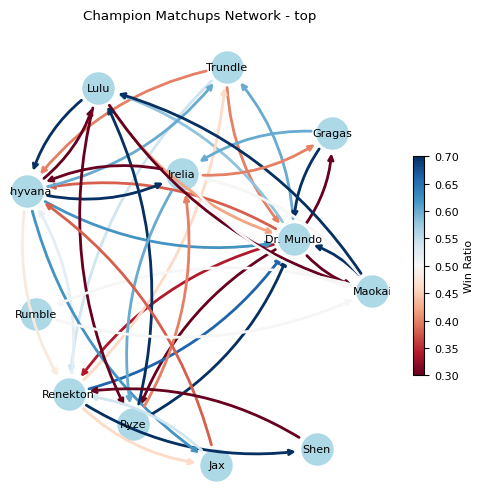

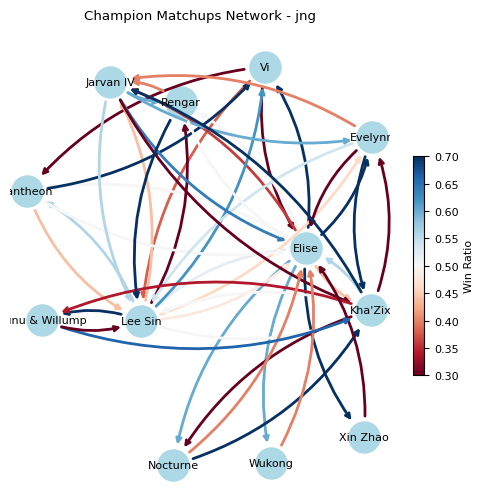

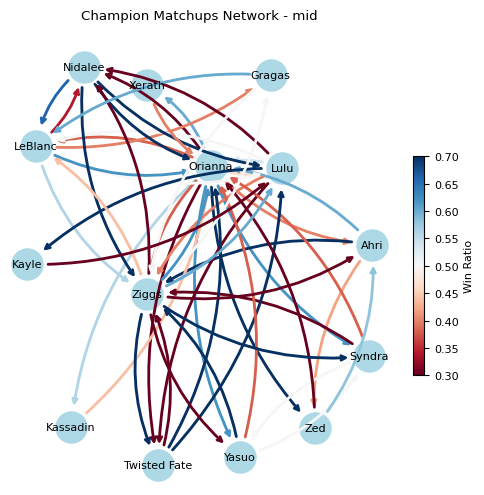

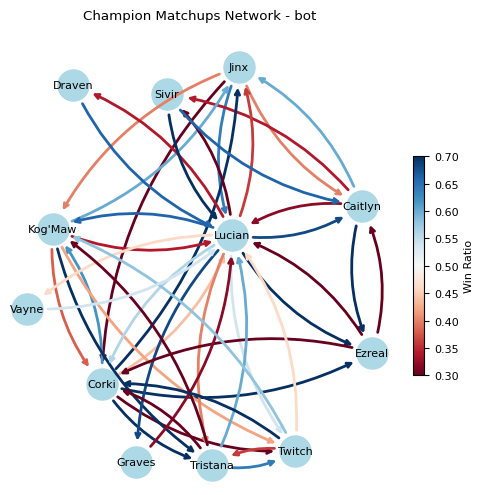

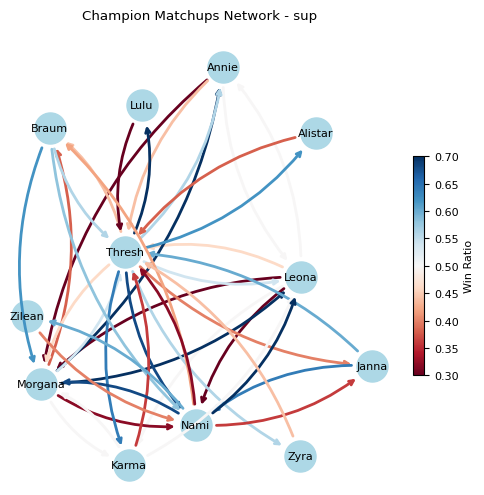

In [ ]:
# Desenho com arestas curvadas
import plotly.graph_objects as go

for r in roles:
#    import networkx as nx
    
#r = roles[0]  # Escolha uma role
    df_role = df.loc[df["role"] == r]
    number_games_min = df_role["pick"].sum() / 200
    # Filtrar apenas matchups significativos
    df_sig = df_role[df_role['pick'] > number_games_min]  # Exemplo: mínimo 50 jogos

    # Criar o grafo
    G = nx.DiGraph()  # <--- Aqui está a mudança crucial

    # Adicionar arestas com direção (main -> vs) e atributo win_ratio
    for _, row in df_sig.iterrows():
        G.add_edge(row['champion_main'], row['champion_vs'], win_ratio=row['win_ratio'])

    # Configurar a figura
    fig, ax = plt.subplots(figsize=(5, 5))
    pos = nx.spring_layout(G, k=2.5, seed=42)  # seed para layout consistente
    #pos = nx.circular_layout(G) 
    #pos = nx.kamada_kawai_layout(G)
    offset = 0.05
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # Aplica deslocamento perpendicular
        dx, dy = x2 - x1, y2 - y1
        dist = (dx**2 + dy**2)**0.5
        offset_x = -dy/dist * offset
        offset_y = dx/dist * offset
    
        if G.has_edge(v, u):  # Se for bidirecional
            plt.annotate("",
                xy=(x2, y2),
                xytext=(x1, y1),
                arrowprops=dict(
                    arrowstyle="->",
                    color=plt.cm.RdBu((G[u][v]['win_ratio'] - 0.4)/0.2),
                    shrinkA=15,
                    shrinkB=15,
                    patchA=None,
                    patchB=None,
                    connectionstyle=f"arc3,rad={0.2}",
                    linewidth=2 + 4*(G[u][v]['win_ratio']/df_sig['pick'].max())
            ))
        """
        ratio = G[u][v]['win_ratio']
        print(G[u][v])
        width = 2 + 4 * (G[u][v]['win_ratio'] / df_sig['pick']).max()
        color = plt.cm.RdBu((ratio - 0.4) / 0.2)  # Normaliza entre 0.4-0.6
        
        # Desenha arestas bidirecionais com curvatura oposta
        if G.has_edge(v, u):
            nx.draw_networkx_edges(
                G, pos, 
                edgelist=[(u, v)],
                edge_color=[color],
                width=width,
                arrowsize=20,
                arrowstyle='-|>',
                connectionstyle=f'arc3,rad={0.3 if u < v else -0.3}',  # Curvatura oposta
                ax=plt.gca()
            )
        else:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                edge_color=[color],
                width=width,
                arrowsize=20,
                ax=plt.gca()
            )
        """

        
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Adicionar colorbar corretamente
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=plt.Normalize(vmin=0.3, vmax=0.7))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label('Win Ratio')

    plt.title(f"Champion Matchups Network - {r}", pad=20)
    plt.axis('off')  # Remove os eixos
    plt.tight_layout()
    plt.show()

In [ ]:
for r in roles:
    fig = plt
    df_role = df.loc[df["role"] == r,:]
    df_pivot = pd.pivot_table(df_role,values="win_ratio",index="champion_main",columns="champion_vs")
    #print(df_pivot.to_string())
    fig, ax = plt.subplots(figsize=(12, 10)) 

    sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0.5,annot_kws={"size":8},ax=ax)
    
    plt.title(f"Win Ratio por Campeão - Role: {r}",pad=20)
    plt.xticks(rotation=45,ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.show()

In [ ]:
for r in roles:
    fig = plt
    df_role = df.loc[df["role"] == r,:]
    df_pivot = pd.pivot_table(df_role,values="win_ratio",index="champion_main",columns="champion_vs")
    #print(df_pivot.to_string())
    fig, ax = plt.subplots(figsize=(12, 10)) 

    sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0.5,annot_kws={"size":8},ax=ax)
    
    plt.title(f"Win Ratio por Campeão - Role: {r}",pad=20)
    plt.xticks(rotation=45,ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.show()

In [ ]:
def calculate_node_size(df,champion):
    df_champion = df[df["champion_main"] == champion]

In [ ]:
for r in roles:
    G = nx.DiGraph()
    edge_list = []
    champions = pd.unique(df.loc[df["role"] == r,["champion_main","champion_vs"]].values.ravel())
    df_role = df.loc[df["role"] == r,:]
    for c in champions:
        G.add_node(c)
    for idx, row in df_role.iterrows():
        G.add_edge(row["champion_main"],row["champion_vs"],weight=row["win_ratio"])
        edge_list.append(row["win_ratio"])
        ...
    #nx.draw(G)
    # G, pos
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_edges(G,pos,alpha=0.3, width=edge_list, edge_color="m")
    #nx.draw_networkx_nodes(H, pos, node_size=nodesize, node_color="#210070", alpha=0.9)
    plt.show()
    ...